# Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    classification_report,
    precision_recall_curve,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

RANDOM_STATE = 42


**Hotel Reservations**
Задача: по информации о бронировании (тип номера, канал, срок до заезда, история клиента, цена и т.д.) предсказать, будет ли бронь отменена.

Практический смысл: помочь отелю уменьшить потери от отмен, лучше планировать загрузку номеров и доход.

Метрики: F1, PR-AUC по классу `Canceled`.

Data Dictionary

- Booking_ID: unique identifier of each booking
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- booking_status: Flag indicating if the booking was canceled or not.

In [2]:
df = pd.read_csv("data/classification/Hotel_Reservations.csv")
df.shape

(36275, 19)

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
# Баланс классов:
print(df["booking_status"].value_counts())
print(df["booking_status"].value_counts(normalize=True).round(2))

booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64
booking_status
Not_Canceled    0.67
Canceled        0.33
Name: proportion, dtype: float64


In [5]:
# пропуски
df.isna().mean().sort_values(ascending=False)

Booking_ID                              0.0
arrival_month                           0.0
no_of_special_requests                  0.0
avg_price_per_room                      0.0
no_of_previous_bookings_not_canceled    0.0
no_of_previous_cancellations            0.0
repeated_guest                          0.0
market_segment_type                     0.0
arrival_date                            0.0
arrival_year                            0.0
no_of_adults                            0.0
lead_time                               0.0
room_type_reserved                      0.0
required_car_parking_space              0.0
type_of_meal_plan                       0.0
no_of_week_nights                       0.0
no_of_weekend_nights                    0.0
no_of_children                          0.0
booking_status                          0.0
dtype: float64

In [6]:
# Целевая переменная: 1 — отменено, 0 — нет
df["target"] = (df["booking_status"] == "Canceled").astype(int)

# Удалим явно бесполезный id, если есть
if "Booking_ID" in df.columns:
    df = df.drop(columns=["Booking_ID"])

# Разделим признаки и цель
X = df.drop(columns=["booking_status", "target"])
y = df["target"]

# Разделение на train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Определяем типы признаков
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

num_cols, cat_cols


(['no_of_adults',
  'no_of_children',
  'no_of_weekend_nights',
  'no_of_week_nights',
  'required_car_parking_space',
  'lead_time',
  'arrival_year',
  'arrival_month',
  'arrival_date',
  'repeated_guest',
  'no_of_previous_cancellations',
  'no_of_previous_bookings_not_canceled',
  'avg_price_per_room',
  'no_of_special_requests'],
 ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'])

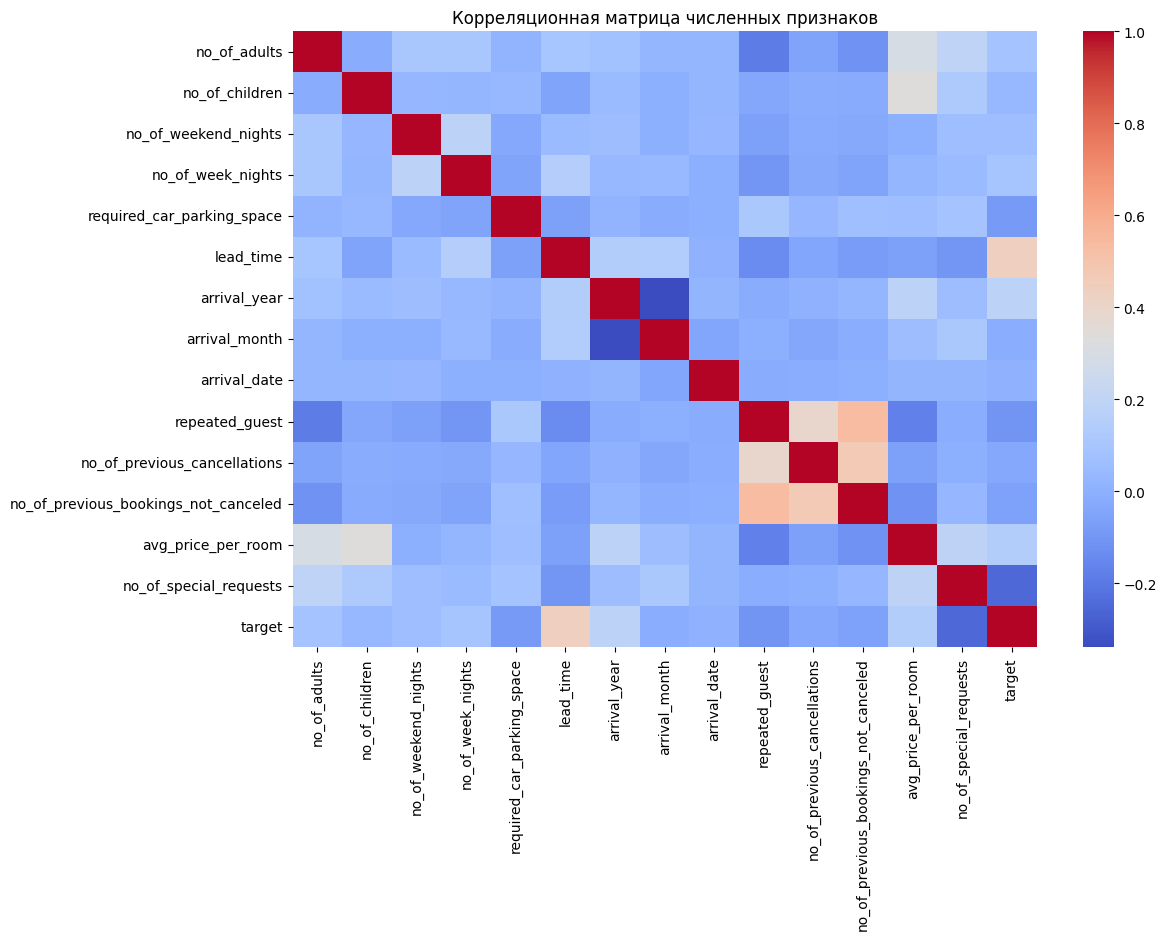

In [7]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
)
plt.title("Корреляционная матрица численных признаков")
plt.show()


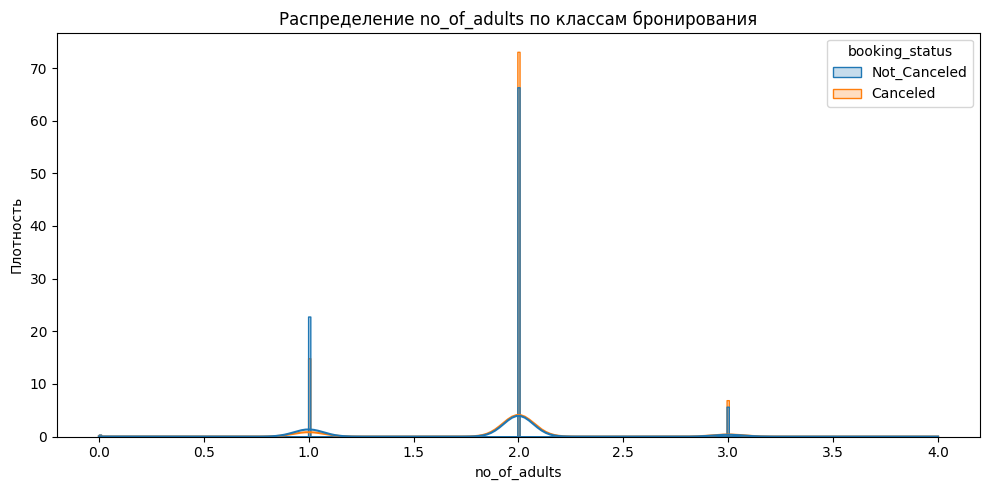

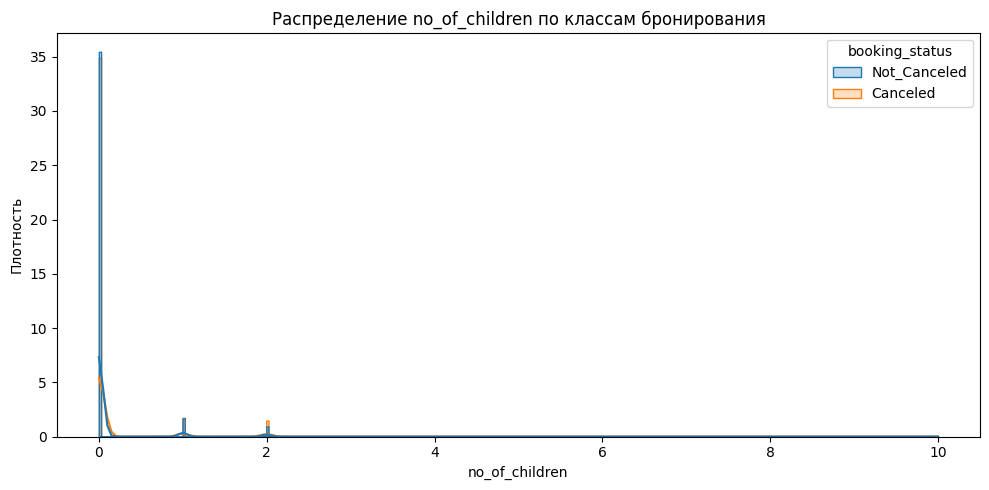

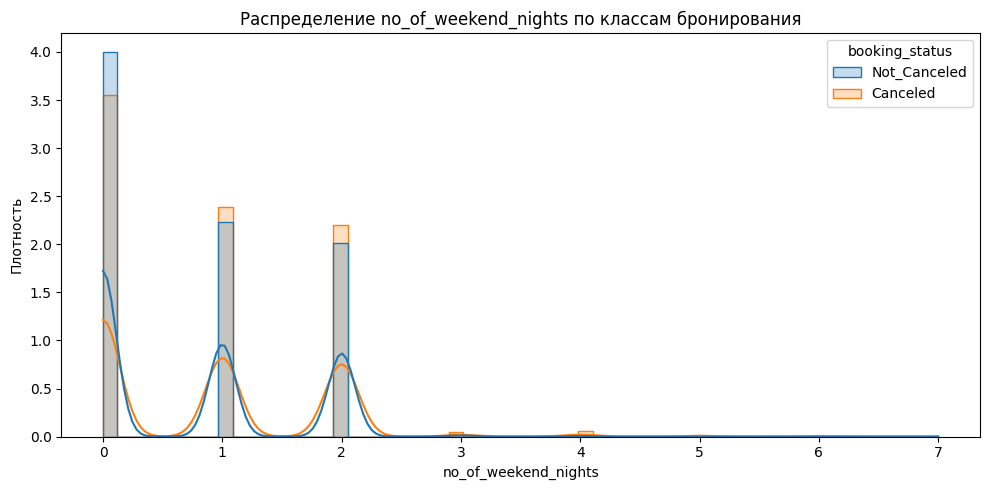

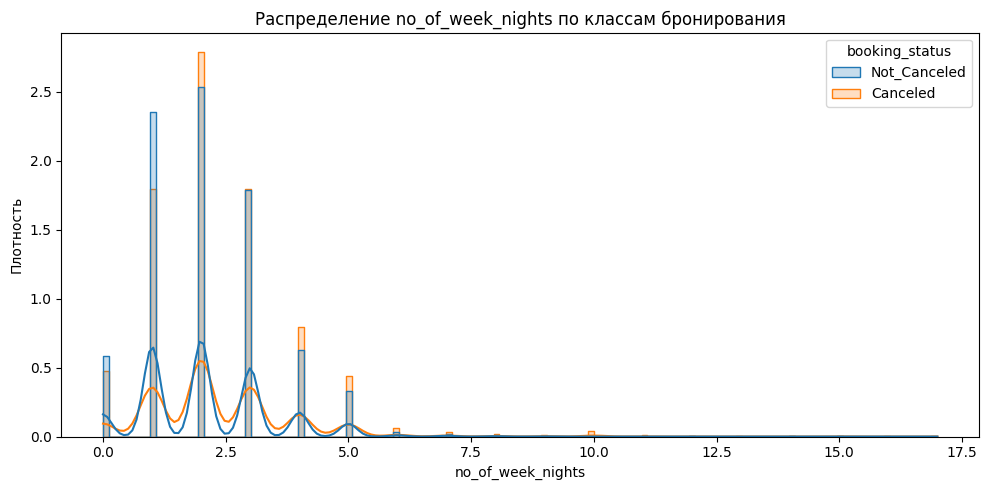

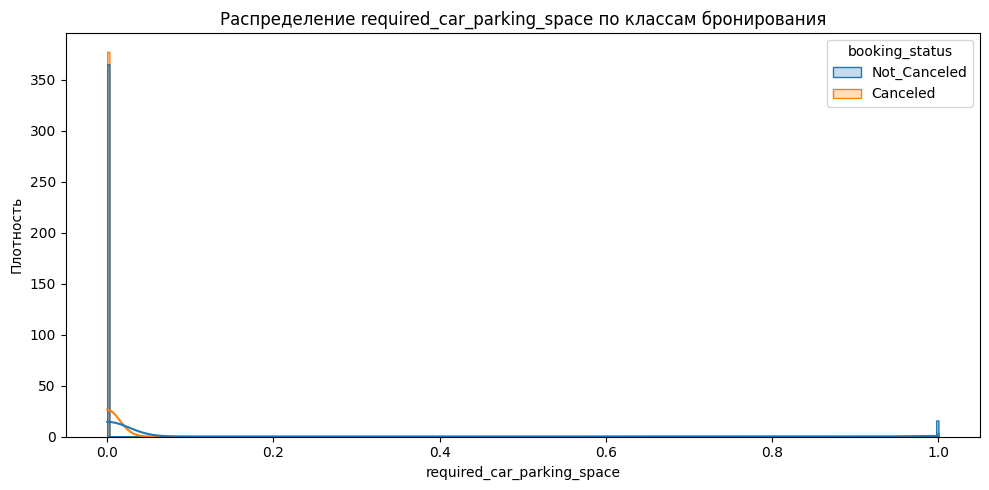

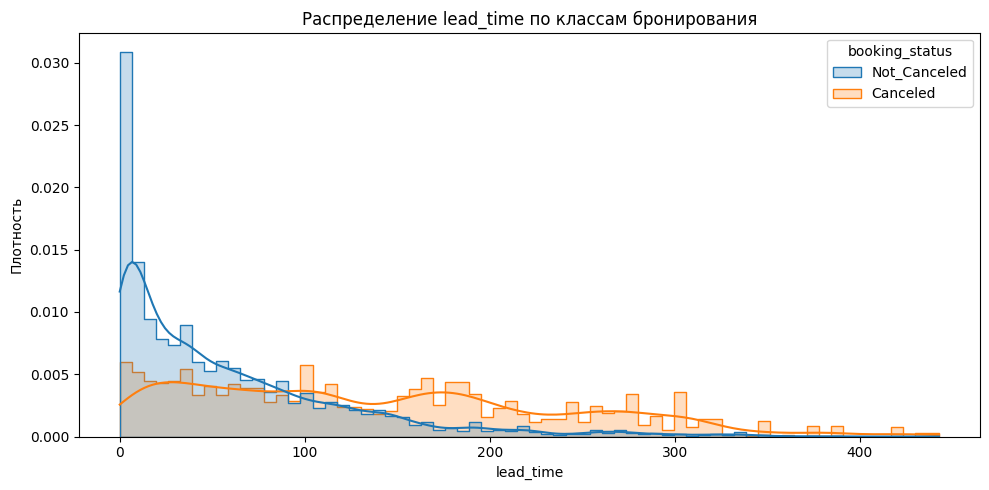

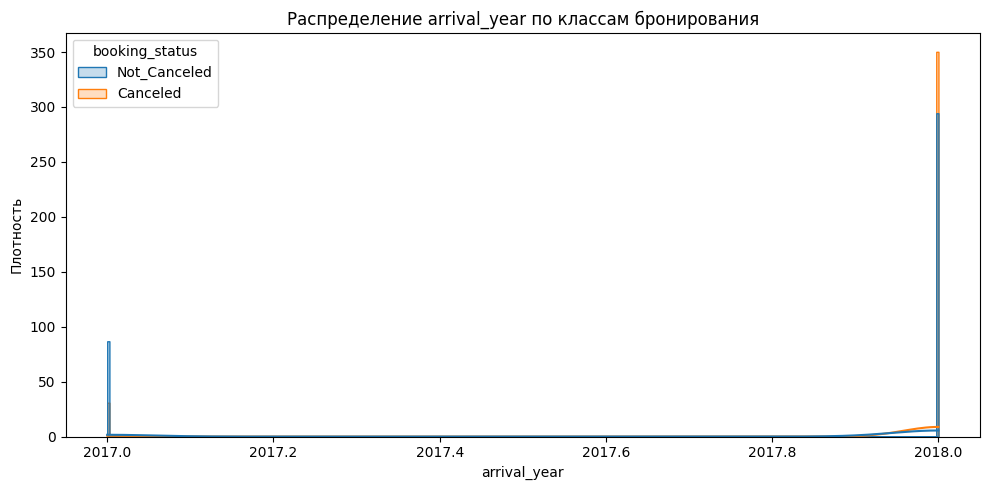

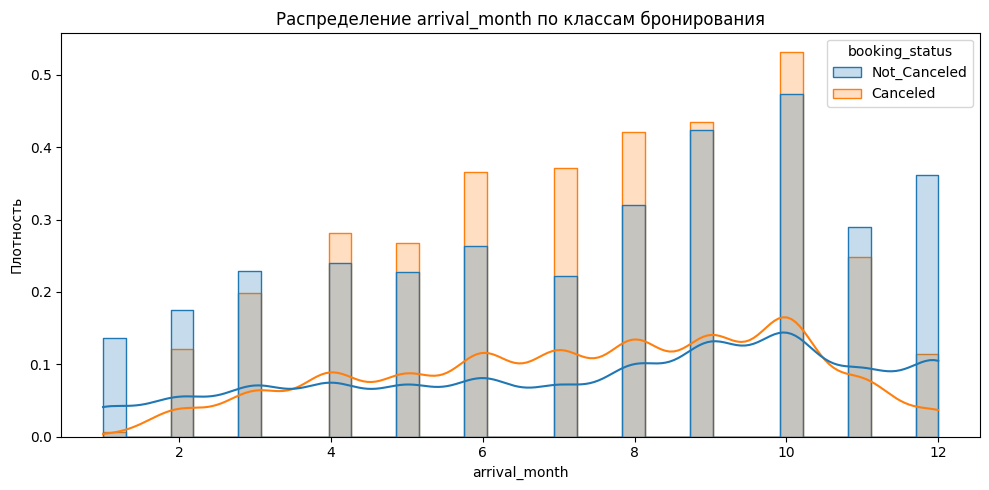

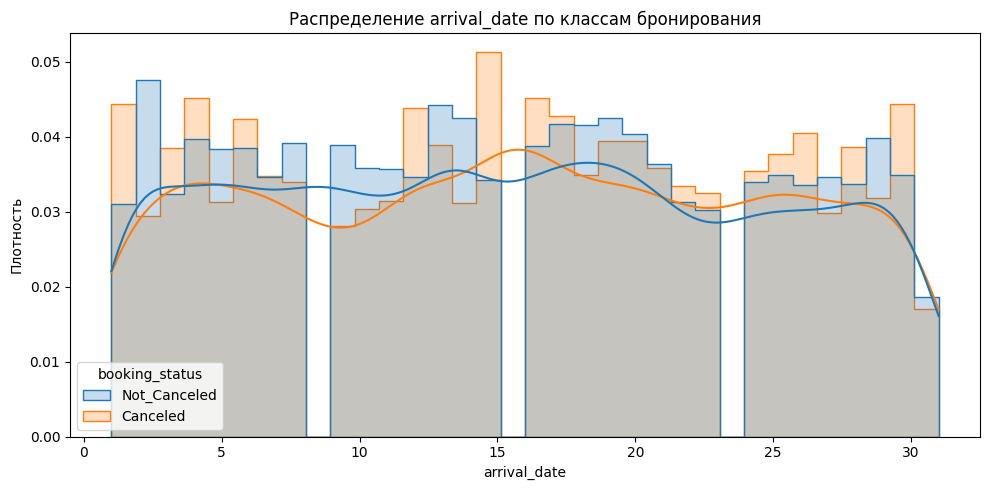

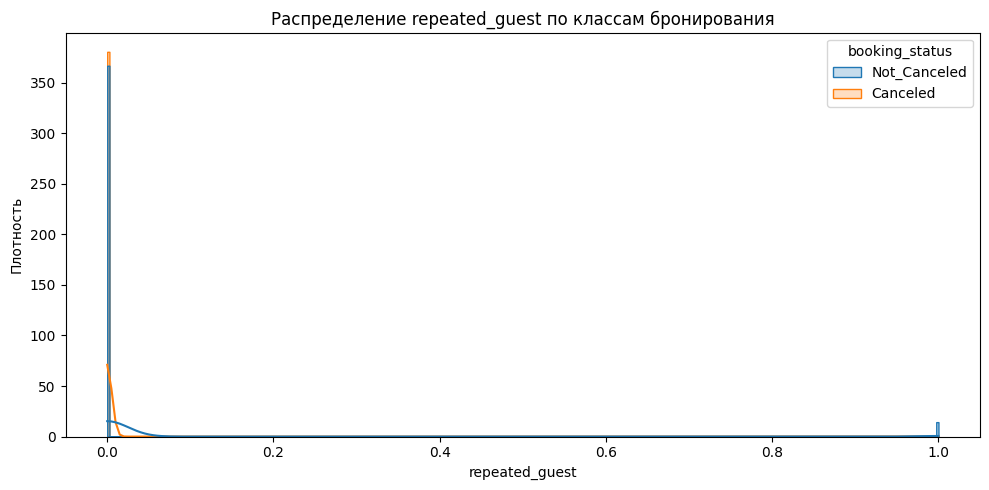

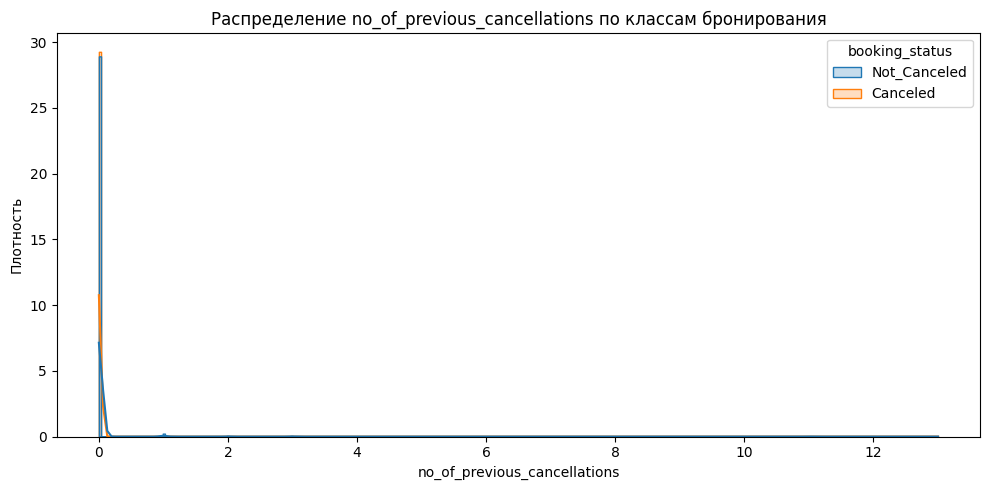

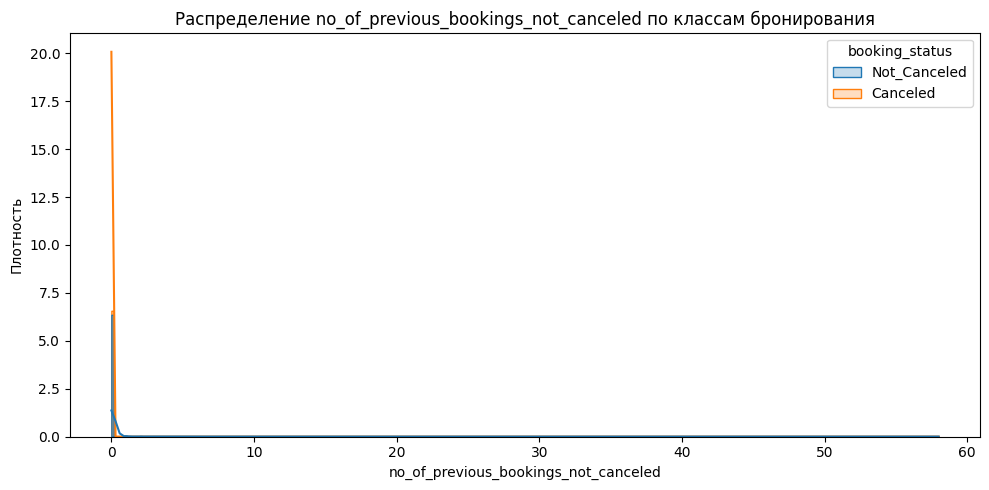

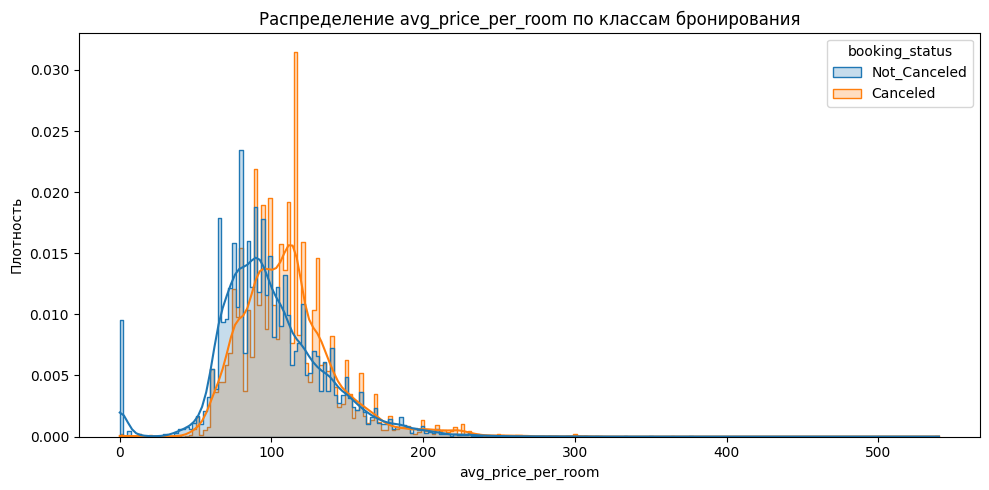

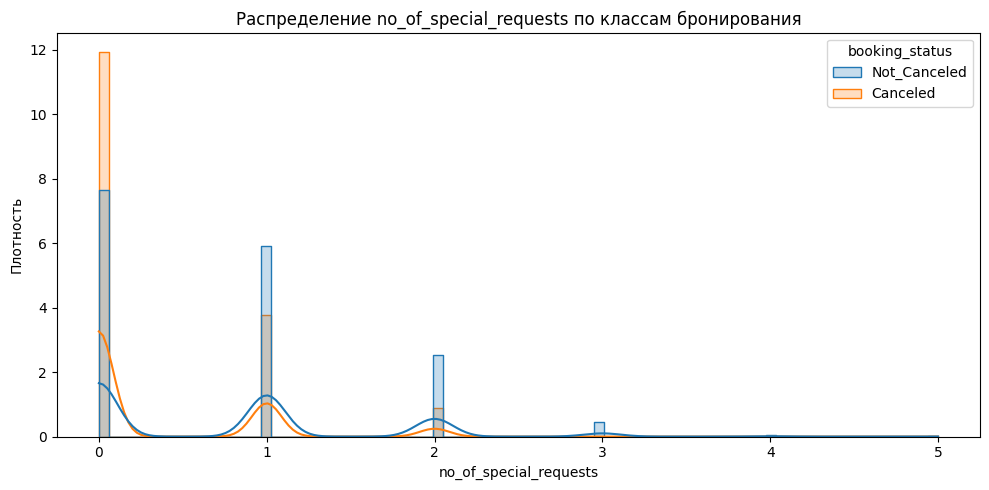

In [8]:
num_cols = [c for c in num_cols if c != "target"]

for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df,
        x=col,
        hue="booking_status",
        kde=True,
        element="step",
        stat="density",
        common_norm=False
    )
    plt.title(f"Распределение {col} по классам бронирования")
    plt.xlabel(col)
    plt.ylabel("Плотность")
    plt.tight_layout()
    plt.show()


## Sklearn Model

In [9]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

rf_clf_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_clf_baseline.fit(X_train, y_train)

y_pred_baseline = rf_clf_baseline.predict(X_test)
y_proba_baseline = rf_clf_baseline.predict_proba(X_test)[:, 1]


In [10]:
rf_clf_baseline

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
f1_baseline = f1_score(y_test, y_pred_baseline)
pr_auc_baseline = average_precision_score(y_test, y_proba_baseline)

print("=== Random Forest — baseline ===")
print(f"F1 (Canceled): {f1_baseline:.4f}")
print(f"PR-AUC (Canceled): {pr_auc_baseline:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_baseline, target_names=["Not_Canceled", "Canceled"]))


=== Random Forest — baseline ===
F1 (Canceled): 0.8526
PR-AUC (Canceled): 0.9356
Classification report:
              precision    recall  f1-score   support

Not_Canceled       0.91      0.95      0.93      4878
    Canceled       0.89      0.82      0.85      2377

    accuracy                           0.91      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.91      0.91      0.91      7255



### Улучшим бейзлайн

In [12]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1. Общее количество ночей
    df["number_of_all_nights"] = (
        df["no_of_weekend_nights"] + df["no_of_week_nights"]
    )
    
    # 2. Общее количество гостей
    df["total_guests"] = df["no_of_adults"] + df["no_of_children"]
    df["has_children"] = (df["no_of_children"] > 0).astype(int)
    
    # 3. Фичи по цене
    df["total_price"] = df["avg_price_per_room"] * df["number_of_all_nights"]
    
    guests = df["total_guests"].replace(0, 1)
    df["price_per_guest"] = df["avg_price_per_room"] / guests
    
    # 4. История клиента
    df["total_previous_bookings"] = (
        df["no_of_previous_cancellations"]
        + df["no_of_previous_bookings_not_canceled"]
    )
    denom = df["total_previous_bookings"].replace(0, 1)
    df["prev_cancel_rate"] = df["no_of_previous_cancellations"] / denom
    
    arrival_dt = pd.to_datetime(
        dict(
            year=df["arrival_year"],
            month=df["arrival_month"],
            day=df["arrival_date"]
        ),
        errors="coerce"
    )
    # убираем строки с некорректной датой
    mask_invalid = arrival_dt.isna()
    print("Удалили строк с некорректной датой:", mask_invalid.sum())
    df = df.loc[~mask_invalid].copy()
    arrival_dt = arrival_dt.loc[~mask_invalid]
    
    df["arrival_dayofweek"] = arrival_dt.dt.dayofweek
    df["arrival_is_weekend"] = df["arrival_dayofweek"].isin([5, 6]).astype(int)
    df["arrival_weekofyear"] = arrival_dt.dt.isocalendar().week.astype("Int64")
    df["arrival_quarter"] = arrival_dt.dt.quarter
    
    # Сезонность (примерная логика)
    df["is_high_season"] = df["arrival_month"].isin([6, 7, 8]).astype(int)
    df["is_low_season"] = df["arrival_month"].isin([11, 12, 1, 2]).astype(int)
    
    return df


In [16]:
# 1. Добавляем фичи к исходному df
df_fe = add_features(df)

# 2. Формируем X и y заново — БЕЗ booking_status и target
feature_cols = [c for c in df_fe.columns if c not in ["booking_status", "target"]]
X_fe = df_fe[feature_cols]
y_fe = df_fe["target"]

# 3. Делаем новый train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE, stratify=y_fe
)

# 4. Пересчитываем списки числовых и категориальных колонок
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# 5. Делаем НОВЫЙ preprocessor под расширенный набор фичей
numeric_transformer_fe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

# 6. Pipeline для тюнинга
rf_clf_tuned = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# 7. GridSearch по новым данным
param_grid_clf = {
    "clf__n_estimators": [400,600, 800],

    # глубина деревьев: оставляем возможность не ограничивать
    "clf__max_depth": [25,30,35],

    # сколько признаков смотреть при сплите
    # "clf__max_features": ["sqrt", "log2", 0.5],

    # регуляризация по количеству объектов в узлах
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1],

    # работа с дисбалансом
    "clf__class_weight": ["balanced"]
}


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_clf = GridSearchCV(
    rf_clf_tuned,
    param_grid_clf,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_fe, y_train_fe)

print("Лучшие параметры (Random Forest):")
print(grid_clf.best_params_)
print("Лучший F1 на кросс-валидации:", grid_clf.best_score_)

best_clf = grid_clf.best_estimator_

y_pred_best = best_clf.predict(X_test_fe)
y_proba_best = best_clf.predict_proba(X_test_fe)[:, 1]

f1_best = f1_score(y_test_fe, y_pred_best)
pr_auc_best = average_precision_score(y_test_fe, y_proba_best)

print("=== Random Forest — улучшенный бейзлайн (с новыми фичами) ===")
print(f"F1 (Canceled): {f1_best:.4f}")
print(f"PR-AUC (Canceled): {pr_auc_best:.4f}")
print("Classification report:")
print(classification_report(y_test_fe, y_pred_best, target_names=["Not_Canceled", "Canceled"]))


Удалили строк с некорректной датой: 37
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Лучшие параметры (Random Forest):
{'clf__class_weight': 'balanced', 'clf__max_depth': 35, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
Лучший F1 на кросс-валидации: 0.8365238746807964
=== Random Forest — улучшенный бейзлайн (с новыми фичами) ===
F1 (Canceled): 0.8452
PR-AUC (Canceled): 0.9278
Classification report:
              precision    recall  f1-score   support

Not_Canceled       0.92      0.93      0.93      4872
    Canceled       0.86      0.83      0.85      2376

    accuracy                           0.90      7248
   macro avg       0.89      0.88      0.89      7248
weighted avg       0.90      0.90      0.90      7248



### Сравнение бейзлайна и улучшенного бейзлайна (Random Forest)

Для Random Forest прироста качества от feature engineering и подбора гиперпараметров фактически не получилось,
так как базовая модель леса (200 деревьев, max_depth=None) уже даёт очень высокие метрики (F1≈0.85, PR-AUC≈0.94), и дальнейший тюнинг даёт лишь колебания на уровне статистического шума.

Вывод: на этом датасете Random Forest с параметрами по умолчанию уже является очень сильным бейзлайном, и сложный гипертюнинг не даёт значимого выигрыша.


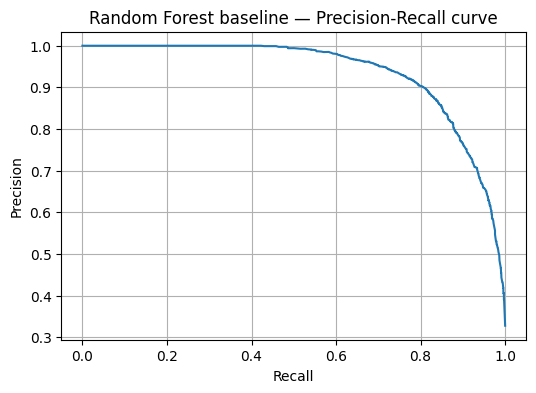

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_baseline) 
plt.figure(figsize=(6, 4)) 
plt.plot(recall, precision) 
plt.xlabel("Recall") 
plt.ylabel("Precision") 
plt.title("Random Forest baseline — Precision-Recall curve") 
plt.grid(True) 
plt.show()


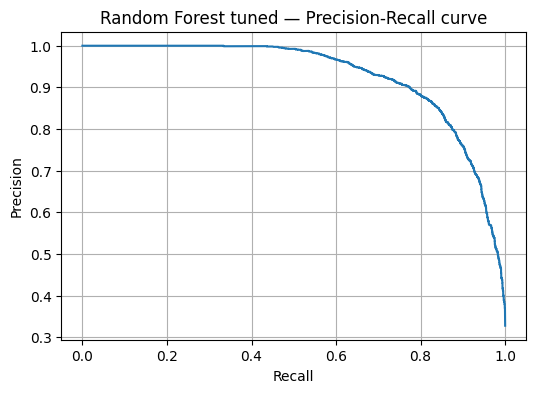

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test_fe, y_proba_best) 
plt.figure(figsize=(6, 4)) 
plt.plot(recall, precision) 
plt.xlabel("Recall") 
plt.ylabel("Precision") 
plt.title("Random Forest tuned — Precision-Recall curve") 
plt.grid(True) 
plt.show()
